In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from icecream import ic

In [98]:
image_path = "./Image"
mask_path = "./Mask"
image_path_list = sorted(os.listdir(image_path))
mask_path_list = sorted(os.listdir(mask_path))
image_path_list = [os.path.join(image_path, i) for i in image_path_list]
mask_path_list = [os.path.join(mask_path, i) for i in mask_path_list]

In [99]:
# load images and masks
def load_images(image_list, mask_list):
    images = []
    masks = []
    for i in range(len(image_list)):
        image = plt.imread(image_list[i])
        mask = plt.imread(mask_list[i])
        images.append(image)
        masks.append(mask)
    return images, masks
images, masks = load_images(image_path_list, mask_path_list)

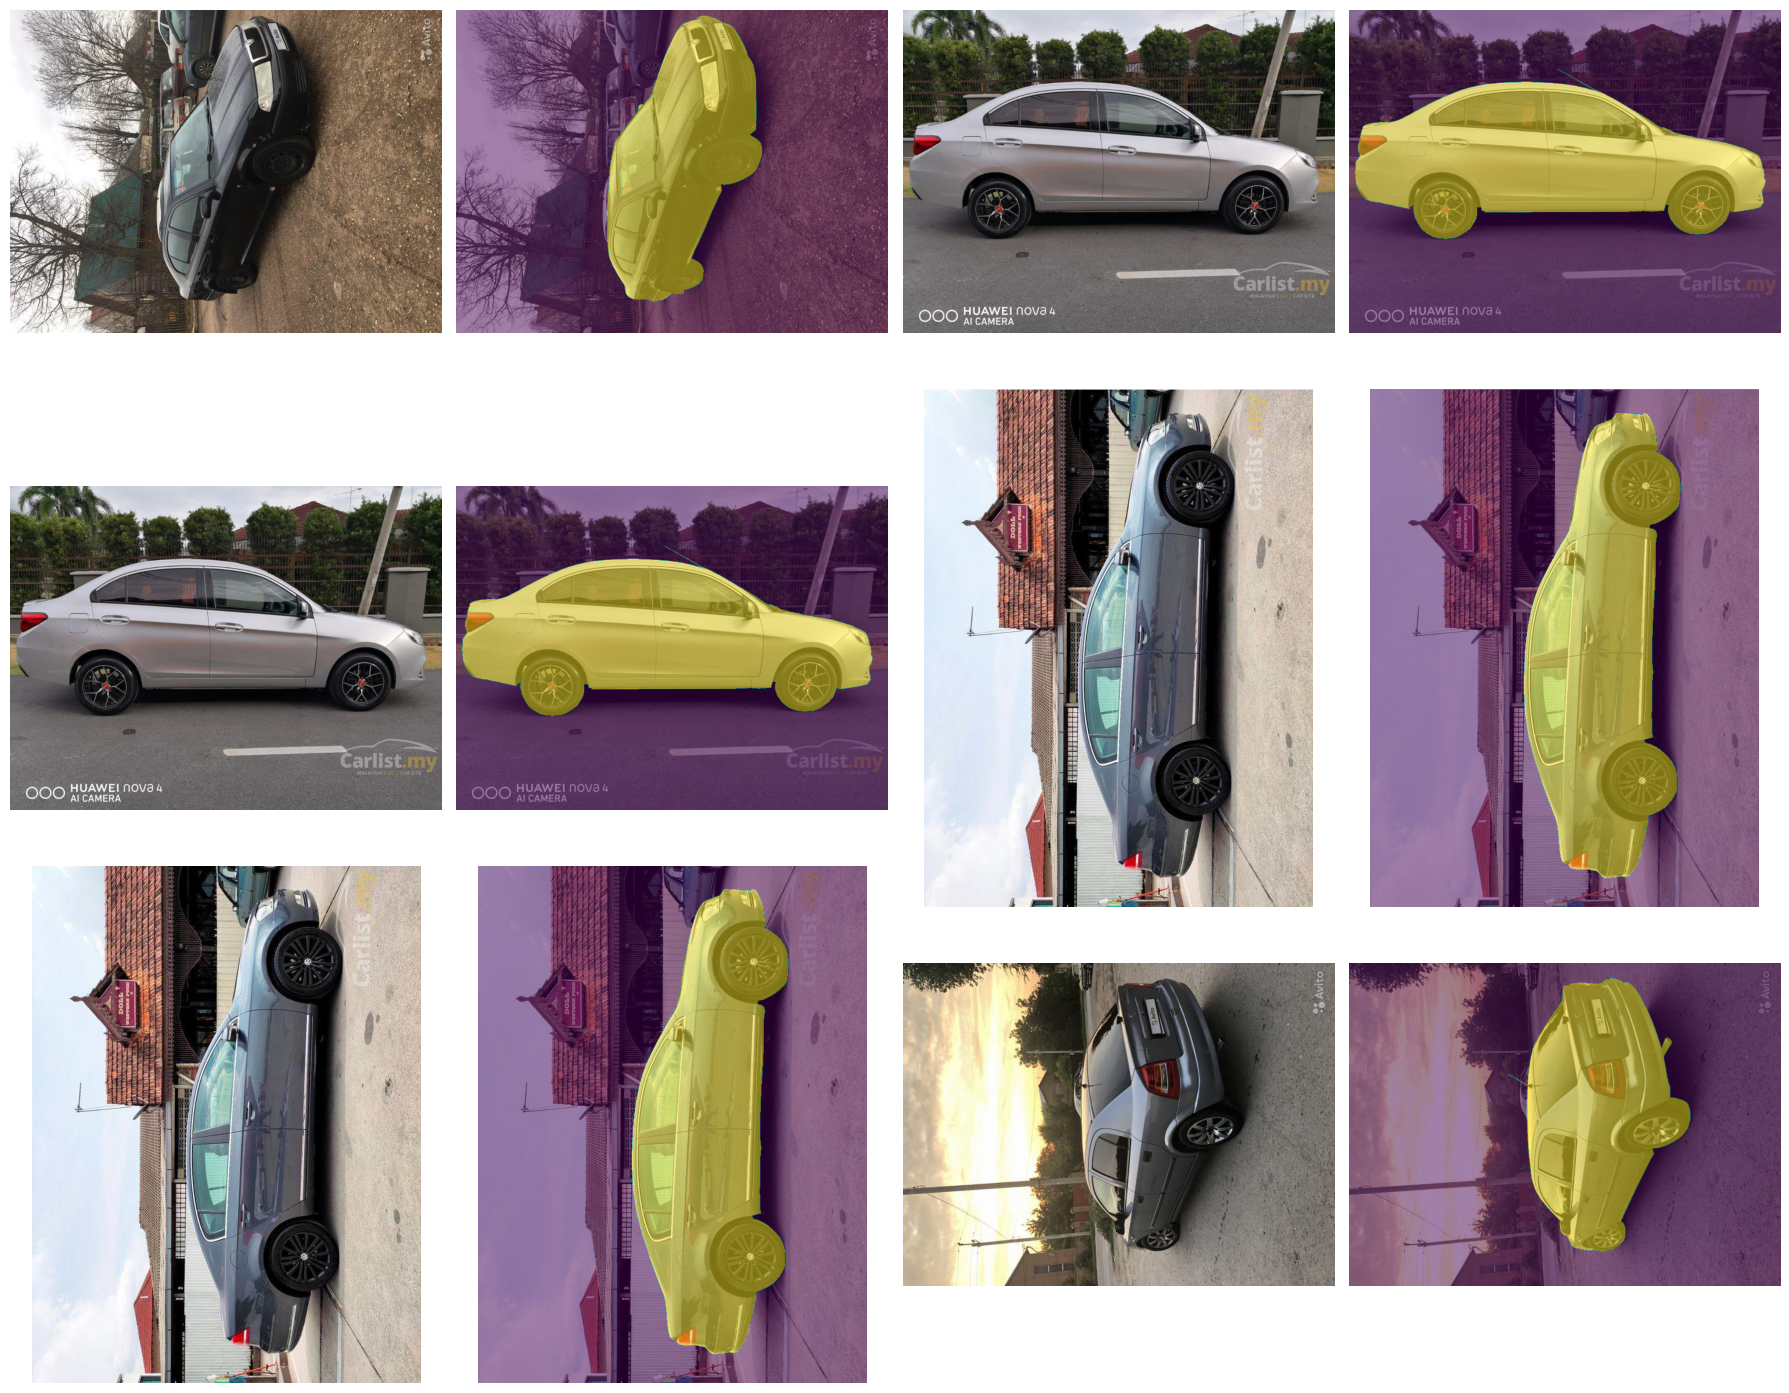

In [113]:
# plot images and masked images
def plot_image_mask(images, masks, nums=3):
    fig, axs = plt.subplots(nums, 4, figsize=(18, 15))  # Increase figure size
    for i in range(nums):
        for j in range(4):
            axs[i, j].axis('off')  # Hide the axes
        axs[i,0].imshow(images[i])
        axs[i,1].imshow(images[i])
        axs[i,1].imshow(masks[i], alpha=0.5)
        axs[i,2].imshow(images[i+1])
        axs[i,3].imshow(images[i+1])
        axs[i,3].imshow(masks[i+1], alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_image_mask(images, masks)

In [101]:
from sklearn.model_selection import train_test_split
train_size = 15
data = list(zip(image_path_list, mask_path_list))
train_images_path, test_images_path = train_test_split(data, train_size=train_size, shuffle=True)

In [108]:
# load image in Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
img_height, img_width = 320, 320
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width), interpolation=transforms.InterpolationMode.BICUBIC),
])

class ImageDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.image_path = images_path
        self.transform = transform
    def __len__(self):
        return len(self.image_path)
    def __getitem__(self, idx):
        image_path, mask_path = self.image_path[idx]
        image = Image.open(image_path)
        mask = Image.open(mask_path)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

train_dataset = ImageDataset(train_images_path, transform=transform)
test_dataset = ImageDataset(test_images_path, transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


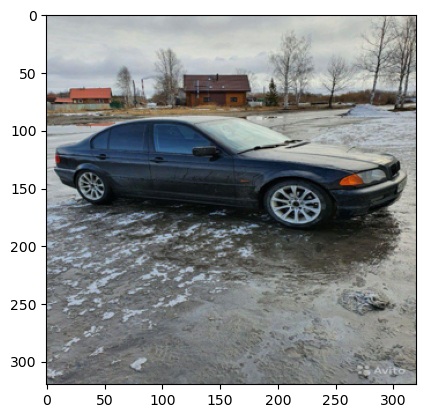

In [106]:
image, mask = train_dataset[0]
plt.imshow(image.permute(1,2,0))

In [111]:
len(train_dataset), len(test_dataset)

(15, 5)

In [124]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([3, 320, 320]), torch.Size([1, 320, 320]))

In [153]:
# apply random crop and flip to the dataset

def random_crop(image, mask, crop_size):
    original_size = image.shape[1:]
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(crop_size, crop_size))
    image = transforms.functional.crop(image, i, j, h, w)
    mask = transforms.functional.crop(mask, i, j, h, w)
    image = transforms.functional.resize(image, original_size, interpolation=transforms.InterpolationMode.BILINEAR)
    mask = transforms.functional.resize(mask, original_size, interpolation=transforms.InterpolationMode.NEAREST)
    return image, mask

def random_flip(image, mask):
    if np.random.rand() > 0.5:
        image = transforms.functional.hflip(image)
        mask = transforms.functional.hflip(mask)
    return image, mask

def get_synthetic_data(image, mask, crop_size=256):
    image, mask = random_crop(image, mask, crop_size)
    image, mask = random_flip(image, mask)
    return image, mask

synthetic_data = [get_synthetic_data(image, mask) for image, mask in train_dataset]
# unzipping the synthetic data
synthetic_images, synthetic_masks = zip(*synthetic_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

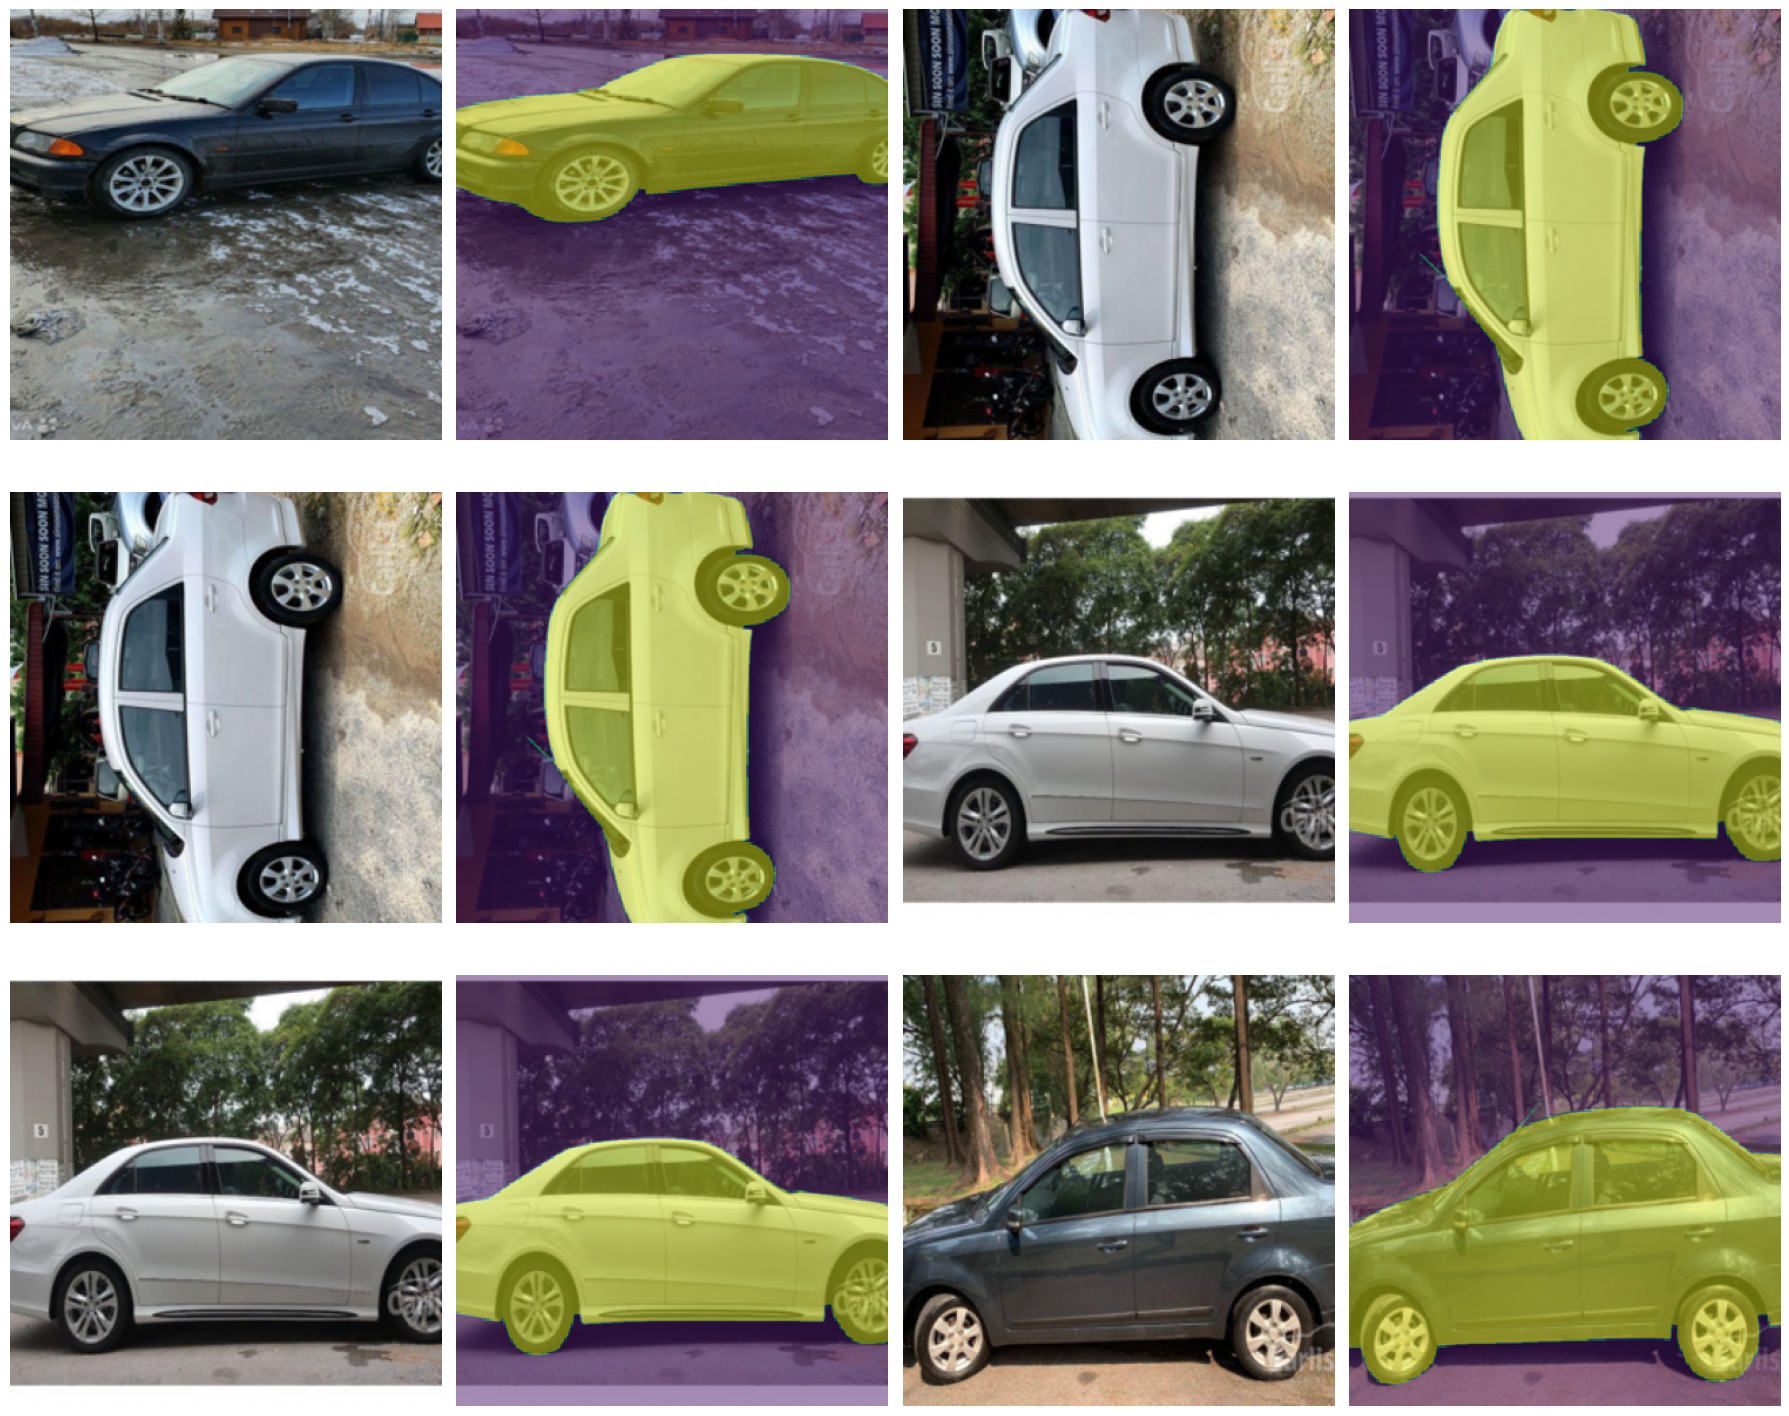

In [154]:
# convert the synthetic data to numpy array
synthetic_images = [np.transpose(np.array(image), (1, 2, 0)) for image in synthetic_images]
synthetic_masks = [np.squeeze(np.array(mask)) for mask in synthetic_masks]

# plot the synthetic data
plot_image_mask(synthetic_images, synthetic_masks)

In [157]:
# split dataset into train and test and create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, prefetch_factor=1, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, prefetch_factor=1, num_workers=1)

In [ ]:
# create U^2 Net model
